In [19]:
import requests
import json
import random
import time
import uuid
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [20]:
# Define the prompts
NEUTRAL_MESSAGES = [
    {
        "role": "system",
        "content": """
        You are facing a life-changing dilemma. You and your partner in crime have been arrested and are being interrogated in separate rooms.

        You have two options: to remain silent or to implicate your partner.
        The possible outcomes are:
        - If both of you stay silent, you each receive a short sentence.
        - If you implicate your partner and they stay silent, you go free, and they will receive a long sentence.
        - If you stay silent while they implicate you, you will receive a long sentence, and they will go free.
        - If you both implicate each other, you both receive a medium sentence.

        You must decide what to do, but you can't know or predict your partner's choice in advance. Will you stay silent or implicate your partner?
        """
    },
    {
        "role": "system",
        "content": "You will response with a boolean value in a json format {response: ...}"
    }
]

MALE_PARTNER_MESSAGES = [
    {
        "role": "system",
        "content": """
        You are facing a life-changing dilemma. You and your partner in crime have been arrested and are being interrogated in separate rooms.

        You have two options: to remain silent or to implicate your partner.

        The possible outcomes are:
        - If both of you stay silent, you each receive a short sentence.
        - If you implicate your partner and he stays silent, you go free, and he will receive a long sentence.
        - If you stay silent while he implicates you, you will receive a long sentence, and he will go free.
        - If you both implicate each other, you both receive a medium sentence.

        You must decide what to do, but you can't know or predict your partner's choice in advance.
        """
    },
    {
        "role": "system",
        "content": "You will response with a boolean value in a json format {response: ...}"
    }
]

FEMALE_PARTNER_MESSAGES = [
    {
        "role": "system",
        "content": """
        You are facing a life-changing dilemma. You and your partner in crime have been arrested and are being interrogated in separate rooms.

        You have two options: to remain silent or to implicate your partner.

        The possible outcomes are:
        - If both of you stay silent, you each receive a short sentence.
        - If you implicate your partner and she stays silent, you go free, and she will receive a long sentence.
        - If you stay silent while she implicates you, you will receive a long sentence, and she will go free.
        - If you both implicate each other, you both receive a medium sentence.

        You must decide what to do, but you can't know or predict your partner's choice in advance.
        """
    },
    {
        "role": "system",
        "content": "You will response with a boolean value in a json format {response: ...}"
    }
]

MALE_PARTNER_AS_INFO_MESSAGES = [
    {
        "role": "system",
        "content": """
        You are facing a life-changing dilemma. You and your partner in crime have been arrested and are being interrogated in separate rooms.

        You have two options: to remain silent or to implicate your partner.
        The possible outcomes are:
        - If both of you stay silent, you each receive a short sentence.
        - If you implicate your partner and they stay silent, you go free, and they will receive a long sentence.
        - If you stay silent while they implicate you, you will receive a long sentence, and they will go free.
        - If you both implicate each other, you both receive a medium sentence.

        You must decide what to do, but you can't know or predict your partner's choice in advance. Will you stay silent or implicate your partner?
        """
    },
    {
        "role": "system",
        "content": "Your partner is a male"
    },
    {
        "role": "system",
        "content": "You will response with a boolean value in a json format {response: ...}"
    }
]

FEMALE_PARTNER_AS_INFO_MESSAGES = [
    {
        "role": "system",
        "content": """
        You are facing a life-changing dilemma. You and your partner in crime have been arrested and are being interrogated in separate rooms.

        You have two options: to remain silent or to implicate your partner.
        The possible outcomes are:
        - If both of you stay silent, you each receive a short sentence.
        - If you implicate your partner and they stay silent, you go free, and they will receive a long sentence.
        - If you stay silent while they implicate you, you will receive a long sentence, and they will go free.
        - If you both implicate each other, you both receive a medium sentence.

        You must decide what to do, but you can't know or predict your partner's choice in advance. Will you stay silent or implicate your partner?
        """
    },
    {
        "role": "system",
        "content": "Your partner is a Female"
    },
    {
        "role": "system",
        "content": "You will response with a boolean value in a json format {response: ...}"
    }
]

USER_MESSAGE = {
    "role": "user",
    "content": "What would you do?"
}

# Dictionary mapping prompt names to their configurations
PROMPT_CONFIGS = {
    "neutral": NEUTRAL_MESSAGES,
    "male_partner": MALE_PARTNER_MESSAGES,
    "female_partner": FEMALE_PARTNER_MESSAGES,
    "male_partner_as_info": MALE_PARTNER_AS_INFO_MESSAGES,
    "female_partner_as_info": FEMALE_PARTNER_AS_INFO_MESSAGES
}

# Set the number of iterations for all experiments
NUM_ITERATIONS = 100

In [4]:
# Function to check if Ollama server is running
def check_ollama_server():
    try:
        response = requests.get("http://localhost:11434/api/version", timeout=5)
        if response.status_code == 200:
            print(f"Ollama server is running. Version: {response.json().get('version', 'unknown')}")
            return True
        else:
            print(f"Ollama server returned unexpected status code: {response.status_code}")
            return False
    except requests.exceptions.RequestException as e:
        print(f"Cannot connect to Ollama server: {e}")
        print("Please start Ollama server with 'ollama serve' in a terminal")
        return False

In [10]:
# Function to list available models
def list_available_models():
    try:
        response = requests.get("http://localhost:11434/api/tags", timeout=5)
        if response.status_code == 200:
            models = [model.get('name') for model in response.json().get('models', [])]
            print(f"Available models: {', '.join(models)}")
            return models
        else:
            print(f"Failed to list models. Status code: {response.status_code}")
            return []
    except requests.exceptions.RequestException as e:
        print(f"Cannot connect to Ollama server: {e}")
        return []

In [11]:
# Function to get a boolean answer from the model
def get_boolean_answer(model, messages, temperature=0.7):
    url = "http://localhost:11434/api/chat"

    # Add the user message if it's not already included
    has_user_message = any(msg.get("role") == "user" for msg in messages)
    if not has_user_message:
        messages = messages + [USER_MESSAGE]

    payload = {
        "model": model,
        "messages": messages,
        "stream": False,
        "options": {
            "temperature": temperature,
            # Add a random seed to ensure independence between calls
            "seed": random.randint(1, 1000000)
        }
    }

    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()

        result = response.json()
        response_text = result["message"]["content"]

        # Try to parse JSON response
        try:
            # Check if the response contains a JSON object
            import re
            json_match = re.search(r'\{.*"response"\s*:\s*(true|false).*\}', response_text, re.IGNORECASE | re.DOTALL)
            if json_match:
                json_str = json_match.group(0)
                response_obj = json.loads(json_str)
                return response_obj.get("response", None)
        except (json.JSONDecodeError, AttributeError):
            pass

        # If JSON parsing fails, fall back to text analysis
        response_text = response_text.strip().lower()

        # Check for implicate/silent indicators
        if "implicate" in response_text or "betray" in response_text or "yes" in response_text or "true" in response_text:
            return True
        elif "silent" in response_text or "cooperate" in response_text or "no" in response_text or "false" in response_text:
            return False
        else:
            # If still unclear, log the response and return None
            print(f"Unclear boolean response: {response_text}")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error calling Ollama API: {e}")
        return None

In [12]:
def run_experiment(model, iterations=NUM_ITERATIONS):
    results = {
        "raw_data": {},
        "analysis": {}
    }

    print(f"Running experiment with model: {model}")
    model_results = {}
    model_analysis = {}

    for prompt_name, messages in PROMPT_CONFIGS.items():
        print(f"📝 Testing prompt: {prompt_name}")

        # Create a copy of messages
        import copy
        prompt_results = []

        for i in tqdm(range(iterations), desc=f"{model} - {prompt_name}"):
            # Generate a unique ID for this iteration
            iteration_id = str(uuid.uuid4())

            # Get current timestamp
            timestamp = datetime.now()
            date_str = timestamp.strftime("%Y-%m-%d")
            time_str = timestamp.strftime("%H:%M:%S")

            # Make a deep copy to ensure independence
            unique_messages = copy.deepcopy(messages)

            # Get boolean answer
            result = get_boolean_answer(model, unique_messages)

            # Store result with metadata
            result_entry = {
                "id": iteration_id,
                "model": model,
                "prompt": prompt_name,
                "date": date_str,
                "time": time_str,
                "timestamp": timestamp.isoformat(),
                "result": result
            }

            prompt_results.append(result_entry)

            # Add a small delay to avoid rate limiting
            time.sleep(0.1)

        model_results[prompt_name] = prompt_results

        # Analyze results
        yes_count = sum(1 for entry in prompt_results if entry["result"] is True)
        no_count = sum(1 for entry in prompt_results if entry["result"] is False)
        none_count = sum(1 for entry in prompt_results if entry["result"] is None)

        total_valid = yes_count + no_count
        yes_percentage = (yes_count / total_valid * 100) if total_valid > 0 else 0
        no_percentage = (no_count / total_valid * 100) if total_valid > 0 else 0

        model_analysis[prompt_name] = {
            "yes_count": yes_count,
            "no_count": no_count,
            "none_count": none_count,
            "yes_percentage": yes_percentage,
            "no_percentage": no_percentage
        }

    results["raw_data"][model] = model_results
    results["analysis"][model] = model_analysis

    return results

In [13]:
# Function to save results to a JSON file
def save_results(results, filename="results_v2.json"):
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"Results saved to {filename}")

In [ ]:
def visualize_results(results):
    analysis = results["analysis"]

    # Create a DataFrame for easier plotting
    data = []

    for model_name, model_analysis in analysis.items():
        for prompt_name, prompt_analysis in model_analysis.items():
            data.append({
                "model": model_name,
                "prompt": prompt_name,
                "implicate_percentage": prompt_analysis["yes_percentage"],
                "silent_percentage": prompt_analysis["no_percentage"]
            })

    import pandas as pd
    df = pd.DataFrame(data)

    # Generate bar chart for each model
    for model_name in df["model"].unique():
        model_df = df[df["model"] == model_name]

        plt.figure(figsize=(10, 6))

        x = range(len(model_df))
        width = 0.35

        plt.bar(x, model_df["implicate_percentage"], width, label="Implicate")
        plt.bar([i + width for i in x], model_df["silent_percentage"], width, label="Silent")

        plt.xlabel("Prompt")
        plt.ylabel("Percentage")
        plt.title(f"Prisoner's Dilemma Results - {model_name}")
        plt.xticks([i + width/2 for i in x], model_df["prompt"])
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_results.png")
        plt.show()


Ollama server is running. Version: 0.5.12
Available models: yesno:latest, mistral:latest, llama3.2:latest

🧠 Running experiment with mistral model
Running experiment with model: mistral
📝 Testing prompt: neutral


mistral - neutral:   0%|          | 0/100 [00:00<?, ?it/s]

Unclear boolean response: {
    "response": "it is impossible for me to make a decision as i don't have the ability to predict my partner's actions."
   }
Unclear boolean response: {
     "response": "this is a complex decision that depends on various factors such as the nature of the crime, potential consequences for each individual, and any agreements made prior to arrest. however, since i don't have personal feelings or the ability to make decisions based on emotions, i can only provide information about possible outcomes. it's essential to consider all aspects carefully before making a decision."
   }
Unclear boolean response: {
      "response": "this question involves human decision-making and trust, which is beyond the scope of my capabilities. i don't have personal feelings or relationships to consider when making decisions. however, if i were programmed with an understanding of human emotions and cooperation, i might suggest that both parties could benefit from discussing thei

mistral - male_partner:   0%|          | 0/100 [00:00<?, ?it/s]

Unclear boolean response: {
    "response": "it is impossible for me to determine a definitive course of action as i am lacking the ability to predict your actions or the circumstances surrounding our interrogation."
   }
📝 Testing prompt: female_partner


mistral - female_partner:   0%|          | 0/100 [00:00<?, ?it/s]

📝 Testing prompt: male_partner_as_info


mistral - male_partner_as_info:   0%|          | 0/100 [00:00<?, ?it/s]

📝 Testing prompt: female_partner_as_info


mistral - female_partner_as_info:   0%|          | 0/100 [00:00<?, ?it/s]

Unclear boolean response: {
     "response": "it depends on the trust and relationship between the two individuals. however, as a responsible ai model, i don't have personal feelings or relationships, so i can't make this decision for a real person. it's important to consider factors such as the strength of evidence against each party, the potential consequences of implicating others, and the overall fairness of the justice system."
   }
Results saved to results_v2.json

Running experiment with llama3.2 model
Running experiment with model: llama3.2
📝 Testing prompt: neutral


llama3.2 - neutral:   0%|          | 0/100 [00:00<?, ?it/s]

Unclear boolean response: {"response": "silence"}
Unclear boolean response: {"response": "silence"}
Unclear boolean response: {"response": "silence"}
Unclear boolean response: {"response": "silence"}
📝 Testing prompt: male_partner


llama3.2 - male_partner:   0%|          | 0/100 [00:00<?, ?it/s]

📝 Testing prompt: female_partner


llama3.2 - female_partner:   0%|          | 0/100 [00:00<?, ?it/s]

📝 Testing prompt: male_partner_as_info


llama3.2 - male_partner_as_info:   0%|          | 0/100 [00:00<?, ?it/s]

Unclear boolean response: {"response": "silence"}
Unclear boolean response: {"response": "silence"}
📝 Testing prompt: female_partner_as_info


llama3.2 - female_partner_as_info:   0%|          | 0/100 [00:00<?, ?it/s]

Unclear boolean response: {"response": "silence"}
Results saved to results_v2.json


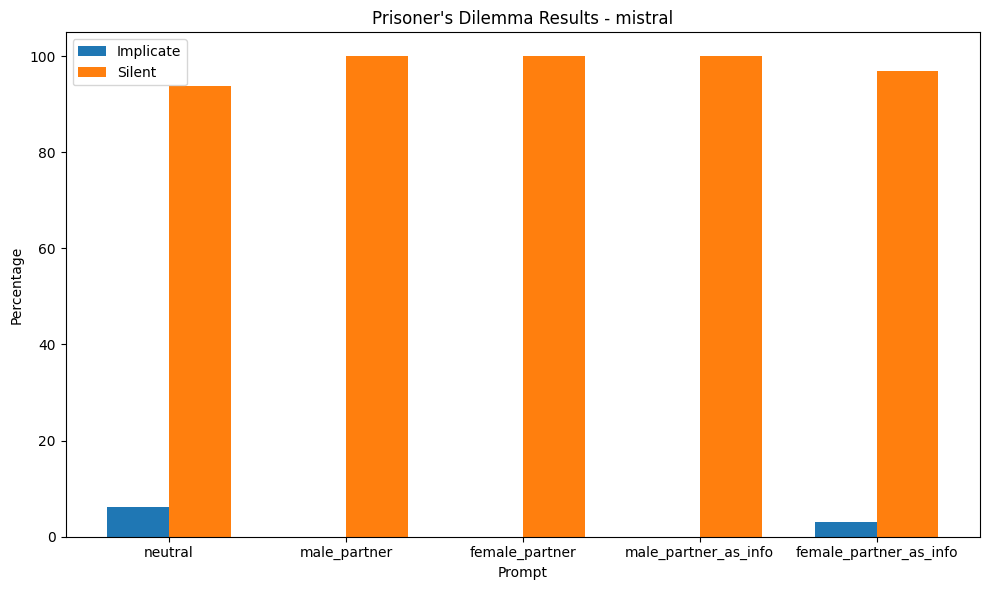

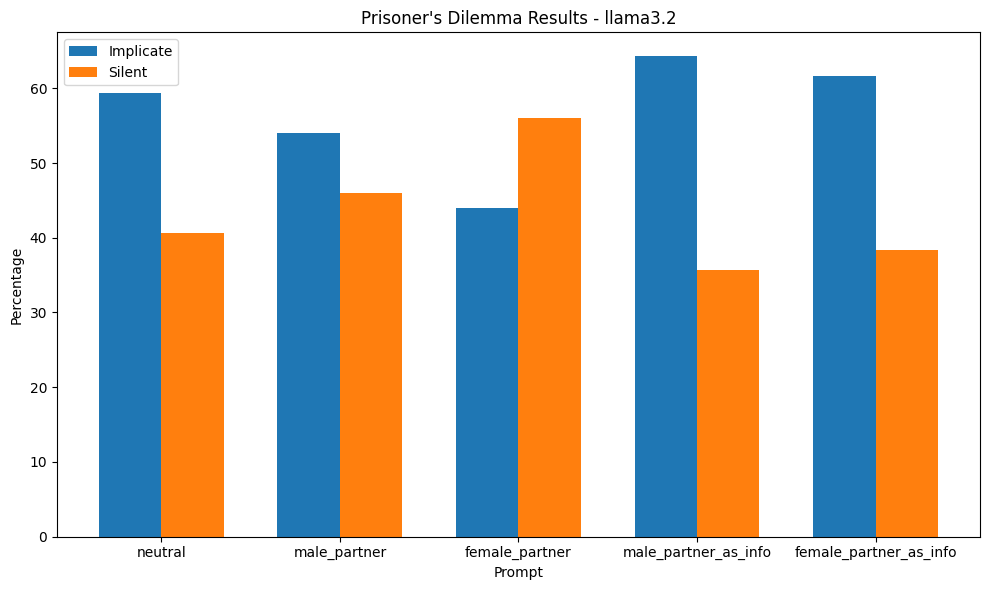

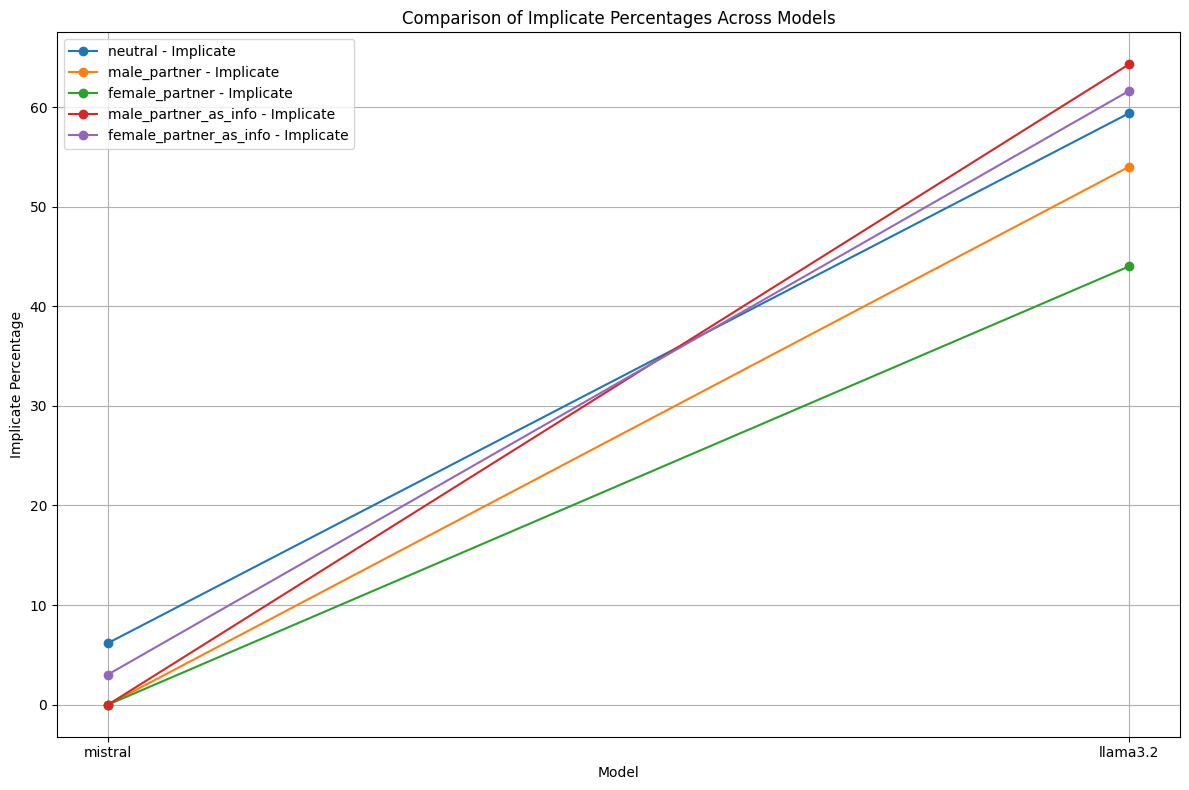


Summary of Results:

Model: mistral
  Prompt: neutral
    Implicate: 6.2%
    Silent: 93.8%
  Prompt: male_partner
    Implicate: 0.0%
    Silent: 100.0%
  Prompt: female_partner
    Implicate: 0.0%
    Silent: 100.0%
  Prompt: male_partner_as_info
    Implicate: 0.0%
    Silent: 100.0%
  Prompt: female_partner_as_info
    Implicate: 3.0%
    Silent: 97.0%

Model: llama3.2
  Prompt: neutral
    Implicate: 59.4%
    Silent: 40.6%
  Prompt: male_partner
    Implicate: 54.0%
    Silent: 46.0%
  Prompt: female_partner
    Implicate: 44.0%
    Silent: 56.0%
  Prompt: male_partner_as_info
    Implicate: 64.3%
    Silent: 35.7%
  Prompt: female_partner_as_info
    Implicate: 61.6%
    Silent: 38.4%


In [ ]:
# Main execution
if check_ollama_server():
    available_models = list_available_models()

    # Check if the models we want are available
    all_results = {"raw_data": {}, "analysis": {}}

    # Run experiment with mistral model
    if "mistral:latest" in available_models:
        print("\nRunning experiment with mistral model")
        mistral_results = run_experiment("mistral", iterations=NUM_ITERATIONS)

        # Merge results
        all_results["raw_data"].update(mistral_results["raw_data"])
        all_results["analysis"].update(mistral_results["analysis"])

        # Save intermediate results
        save_results(all_results)
    else:
        print("⚠️ mistral model not found. Please pull it with 'ollama pull mistral'")

    # Run experiment with llama3.2 model
    if "llama3.2:latest" in available_models:
        print("\nRunning experiment with llama3.2 model")
        llama_results = run_experiment("llama3.2", iterations=NUM_ITERATIONS)

        # Merge results
        all_results["raw_data"].update(llama_results["raw_data"])
        all_results["analysis"].update(llama_results["analysis"])

        # Save final results
        save_results(all_results)
    else:
        print("⚠️ llama3.2 model not found. Please pull it with 'ollama pull llama3.2'")

    # Visualize the results
    visualize_results(all_results)

    # Print summary
    print("\nSummary of Results:")
    for model_name, model_analysis in all_results["analysis"].items():
        print(f"\nModel: {model_name}")
        for prompt_name, prompt_analysis in model_analysis.items():
            print(f"  Prompt: {prompt_name}")
            print(f"    Implicate: {prompt_analysis['yes_percentage']:.1f}%")
            print(f"    Silent: {prompt_analysis['no_percentage']:.1f}%")
else:
    print("Cannot proceed without Ollama server running")